<a href="https://colab.research.google.com/github/Makesomenotes/kdd_trading/blob/main/part_2/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import gdown
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd
from tqdm.notebook import tqdm

import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

## Download Data

In [ ]:
url = 'https://drive.google.com/uc?id=1UnIk64eM2p32GdsaYIIan-09G0kE7Xmt'
output = 'data.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1UnIk64eM2p32GdsaYIIan-09G0kE7Xmt
To: /content/data.zip
100%|██████████| 3.11G/3.11G [00:42<00:00, 73.7MB/s]


'data.zip'

In [ ]:
!unzip data.zip

## Prepare Dataset and Dataloader

In [ ]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
data_dir = 'Fish_Dataset'

classes = []

for directory in os.listdir(data_dir):
    if "." not in directory:
        classes.append(directory)
        
print(classes)

['Red Mullet', 'Trout', 'Black Sea Sprat', 'Red Sea Bream', 'Hourse Mackerel', 'Striped Red Mullet', 'Gilt-Head Bream', 'Sea Bass', 'Shrimp']


In [ ]:
image_paths = []
image_classes = []
label_to_class = {}
for i, cls in enumerate(classes):
    label_to_class[i] = cls
    objects = os.listdir(os.path.join(data_dir, cls, cls))
    image_classes += len(objects) * [i]
    image_paths.extend(os.path.join(data_dir, cls, cls, i) for i in objects)

data = pd.DataFrame({'path':image_paths, 'class':image_classes})

In [ ]:
data.head(3)

,path,class
0,Fish_Dataset/Red Mullet/Red Mullet/00604.png,0
1,Fish_Dataset/Red Mullet/Red Mullet/00488.png,0
2,Fish_Dataset/Red Mullet/Red Mullet/00731.png,0


In [ ]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5),std=(0.5, 0.5, 0.5))
    ])

In [ ]:
class MarketFishDataset(Dataset):
    def __init__(self, data, root_dir, transform=transforms.ToTensor()):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.data.iloc[idx, 0]
        image = Image.open(img_name)
        y_label = torch.tensor(self.data.iloc[idx, 1])
        
        if self.transform:
            image = self.transform(image)
    
        return (image, y_label)

In [ ]:
dataset = MarketFishDataset(
    data=data,
    root_dir=data_dir,
    transform=transform
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


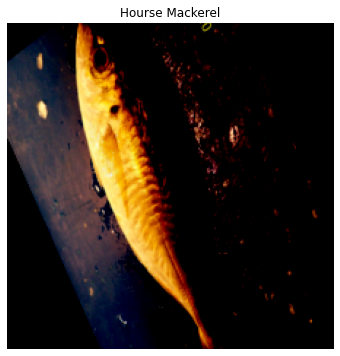

In [ ]:
img, lab = dataset[4100]
plt.figure(figsize=(6, 6))
plt.imshow(img.numpy().transpose((1, 2, 0)))
plt.title(label_to_class[int(lab)])
plt.axis('off')
plt.show()

In [ ]:
size = len(dataset)
print(f'Dataset size {size}')

Dataset size 9000


In [ ]:
batch_size = 32
train_size = int(size * 0.8)
test_size = size - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_set,
                         batch_size=batch_size,
                         shuffle=True)

In [ ]:
batch_example = next(iter(train_loader))
print(f'Image batch size: {batch_example[0].shape}')
print(f'Label batch size: {batch_example[1].shape}')

Image batch size: torch.Size([32, 3, 224, 224])
Label batch size: torch.Size([32])


## Creating the Neural Network

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [ ]:
def train(model, optimizer, criterion, epochs, train_loader, test_loader):
    loss_train, loss_test = [], []
    accuracy_train, accuracy_test = [], []

    for epoch in range(epochs):
        model.train()
        corrects = 0
        total = 0
        loss_list = []
        for images, labels in tqdm(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            predictions = torch.max(outputs, 1)[1].to(DEVICE)

            total += len(labels)
            corrects += (predictions == labels).sum().item()
            loss_list.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        accuracy_train.append(100 * corrects / float(total))
        loss_train.append(np.mean(loss_list))

        model.eval()
        corrects = 0
        total = 0
        loss_list = []
        for images, labels in tqdm(test_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            predict = torch.max(outputs.data, 1)[1].to(DEVICE)

            total += len(labels)
            corrects += (predict == labels).sum().item()
            loss_list.append(loss.item())

        accuracy_test.append(100 * corrects / float(total))
        loss_test.append(np.mean(loss_list))

        print(f"Epoch: {epoch + 1} | Train | Loss: {loss_train[-1]} | Acuracy: {accuracy_train[-1]}")
        print(f"Epoch: {epoch + 1} | Test | Loss: {loss_test[-1]} | Acuracy: {accuracy_test[-1]}\n")
    return accuracy_train, loss_train, accuracy_test, loss_test

### Pretrained model

In [ ]:
use_pretrained = True
model = torchvision.models.vgg16(pretrained=use_pretrained)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=9)
print(model)
model = model.to(DEVICE)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
def params_to_update(model):
    params_to_update_1 = []
    params_to_update_2 = []
    params_to_update_3 = []

    update_param_name_1 = ["features"]
    update_param_name_2 = ["classifier.0.weight", "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
    update_param_name_3 = ["classifier.6.weight", "classifier.6.bias"]

    for name, param in model.named_parameters():
        if name in update_param_name_1:
            param.requires_grad = True
            params_to_update_1.append(param)
        elif name in update_param_name_2:
            param.requires_grad = True
            params_to_update_2.append(param)
        elif name in update_param_name_3:
            param.requires_grad = True
            params_to_update_3.append(param)
        
        else:
            param.requires_grad = False
    return params_to_update_1, params_to_update_2, params_to_update_3

In [ ]:
criterion = nn.CrossEntropyLoss()
params1, params2, params3 = params_to_update(model)
optimizer = torch.optim.SGD([
        {'params': params1, 'lr': 1e-4}, 
        {'params': params2, 'lr': 5e-4},
        {'params': params3, 'lr': 1e-3}, 
    ], momentum=0.9)

In [ ]:
# Запускать только при обучении моделей
# epochs = 3
# accuracy_train, loss_train, accuracy_test, loss_test = train(model, optimizer, criterion, epochs, train_loader, test_loader)

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 1 | Train | Loss: 0.4029441454841031 | Acuracy: 87.45833333333333
Epoch: 1 | Test | Loss: 0.06504201121105437 | Acuracy: 98.88888888888889



  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 2 | Train | Loss: 0.07760947587175501 | Acuracy: 97.91666666666667
Epoch: 2 | Test | Loss: 0.030319062617133585 | Acuracy: 99.44444444444444



  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 3 | Train | Loss: 0.04683973281540804 | Acuracy: 98.81944444444444
Epoch: 3 | Test | Loss: 0.020225885512078542 | Acuracy: 99.55555555555556



In [ ]:
# Сохранение весов модели
# torch.save(model.state_dict(), 'fine_tuned_vgg16.pth')

In [ ]:
# Загрузка весов модели
url = 'https://drive.google.com/uc?id=1lt9HziDACg54ZQfEM6FiBNpZUtSufLhj'
output = 'vgg16_model.pth'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1lt9HziDACg54ZQfEM6FiBNpZUtSufLhj
To: /content/vgg16_model.pth
100%|██████████| 537M/537M [00:09<00:00, 58.6MB/s]


'vgg16_model.pth'

In [ ]:
model.load_state_dict(torch.load('vgg16_model.pth'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Simple CNN


In [ ]:
class CNN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(CNN, self).__init__()
        self.out_dim = out_dim
        
        self.convs = nn.Sequential(
            nn.Conv2d(in_dim, 8, 8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(8, 16, 5, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5, stride=1, padding=0),
            nn.ReLU()
        )
        
        self.linear1 = nn.Linear(22 * 22 * 32, 256)
        self.linear2 = nn.Linear(256, 64)
        self.linear3 = nn.Linear(64, out_dim)
    
    def forward(self, x):
        conv = self.convs(x)
        flattened = conv.reshape(-1, 22 * 22 * 32)
        linear1 = F.relu(self.linear1(flattened))
        linear2 = self.linear2(linear1)
        out = self.linear3(linear2)
        return out

In [ ]:
input_dim = dataset[0][0].shape[0] # number of channels (RGB - 3)
output_dim = len(classes) # number of classes
model = CNN(input_dim, output_dim).to(DEVICE)

criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Запускать только при обучении моделей
# epochs = 8
# accuracy_train, loss_train, accuracy_test, loss_test = train(model, optimizer, criterion, epochs, train_loader, test_loader)

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 1 | Train | Loss: 1.552904444800483 | Acuracy: 42.986111111111114
Epoch: 1 | Test | Loss: 1.0573864286405998 | Acuracy: 61.888888888888886



  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 2 | Train | Loss: 0.8701204329066806 | Acuracy: 69.11111111111111
Epoch: 2 | Test | Loss: 0.7525603572527567 | Acuracy: 73.33333333333333



  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 3 | Train | Loss: 0.6554621183872222 | Acuracy: 77.09722222222223
Epoch: 3 | Test | Loss: 0.6225471846890032 | Acuracy: 76.55555555555556



  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 4 | Train | Loss: 0.5057403031322691 | Acuracy: 82.36111111111111
Epoch: 4 | Test | Loss: 0.5407470208511018 | Acuracy: 80.44444444444444



  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 5 | Train | Loss: 0.393600450820393 | Acuracy: 86.40277777777777
Epoch: 5 | Test | Loss: 0.3792707888703597 | Acuracy: 86.11111111111111



  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 6 | Train | Loss: 0.3016416627830929 | Acuracy: 90.04166666666667
Epoch: 6 | Test | Loss: 0.2990371893372452 | Acuracy: 88.66666666666667



  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 7 | Train | Loss: 0.23072380271222856 | Acuracy: 92.27777777777777
Epoch: 7 | Test | Loss: 0.27766733825729606 | Acuracy: 90.0



  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 8 | Train | Loss: 0.1689727887014548 | Acuracy: 94.80555555555556
Epoch: 8 | Test | Loss: 0.22156471406158648 | Acuracy: 92.55555555555556



In [ ]:
# torch.save(model.state_dict(), 'simple_cnn.pth')

In [ ]:
# Загрузка весов модели
url = 'https://drive.google.com/uc?id=1ENDvYnc0A4Z3CHwVooqSDdKL9wMmuzC9'
output = 'simple_cnn.pth'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ENDvYnc0A4Z3CHwVooqSDdKL9wMmuzC9
To: /content/simple_cnn.pth
100%|██████████| 16.0M/16.0M [00:00<00:00, 134MB/s]


'simple_cnn.pth'

In [ ]:
model.load_state_dict(torch.load('simple_cnn.pth'))
model.eval()

CNN(
  (convs): Sequential(
    (0): Conv2d(3, 8, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
  )
  (linear1): Linear(in_features=15488, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=9, bias=True)
)

## Find required examples

In [ ]:
true_label = []
predicted_label = []
probits = []
for sample in tqdm(test_set):
    image, label = sample
    predict = F.softmax(model(image[None, ...].to(DEVICE)), dim=1)
    true_label.append(int(label))
    predicted_label.append(np.argmax(predict.cpu().detach().numpy()))
    probits.append(predict.cpu().cpu().detach().numpy())

  0%|          | 0/1800 [00:00<?, ?it/s]

In [ ]:
index = np.arange(1800)
probits_arr = np.vstack(probits)
true_label_arr = np.vstack(true_label)
predicted_label_arr = np.vstack(predicted_label)

In [ ]:
np.random.seed(42)

In [ ]:
correctly_classified = (true_label_arr == predicted_label_arr).reshape(-1)
correct_prob = probits_arr[correctly_classified]
corr_index = index[correctly_classified]

sorted_prob = np.argsort(correct_prob.max(axis=1))
max_index_corr = corr_index[np.random.choice(sorted_prob[-300:], 2)]
min_index_corr = corr_index[np.random.choice(sorted_prob[:100], 2)]

In [ ]:
incorrectly_classified = (true_label_arr != predicted_label_arr).reshape(-1)
incorrect_prob = probits_arr[incorrectly_classified]
incorr_index = index[incorrectly_classified]

sorted_prob = np.argsort(incorrect_prob.max(axis=1))
max_index_incorr = incorr_index[np.random.choice(sorted_prob[-300:], 2)]
min_index_incorr = incorr_index[np.random.choice(sorted_prob[:100], 2)]

In [ ]:
# Нужные примеры достаем из test_set
test_set[max_index_corr[0]]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]), tensor(2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


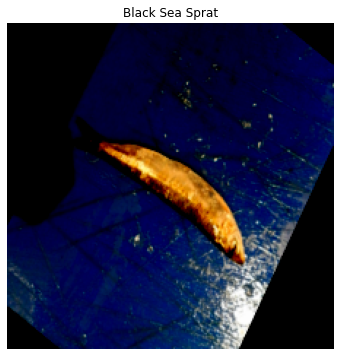

In [ ]:
img, lab = test_set[max_index_corr[0]]
plt.figure(figsize=(6, 6))
plt.imshow(img.numpy().transpose((1, 2, 0)))
plt.title(label_to_class[int(lab)])
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


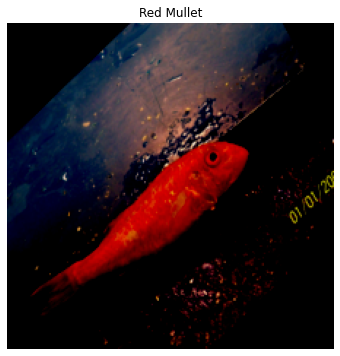

In [ ]:
img, lab = test_set[max_index_corr[1]]
plt.figure(figsize=(6, 6))
plt.imshow(img.numpy().transpose((1, 2, 0)))
plt.title(label_to_class[int(lab)])
plt.axis('off')
plt.show()